In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import quandl
import datetime as dt
quandl.ApiConfig.api_key = "9zu342hfxo1abY1pcd67"
ALPHAVANTAGE_API_KEY = "7GI26HCQ94CQ9SL0"
import seaborn as sns
sns.set()

import statsmodels.api as sm

In [2]:
def download_financial_data(name, source, startdate = '2000-01-01', enddate = dt.date.today()):
    df = data.DataReader(name, source,startdate, enddate)
    return df

We aim to determine the Hurst exponent of a stock price/return, assuming that the driving process of volatility is a fractional Brownian motion.

Assume the price process is lognormal. Then:

$$ ln(\frac{S_t}{S_0}) = (\mu - \frac{\sigma^2}2)dt + \sigma dW_t$$

We claim that:

$$\delta ln(\sigma_t) = \gamma_0 \delta X_t$$

If this is the case:
$$E[|\delta(ln\sigma_t)|^m] = \gamma_0^m E[|\delta X_t|^m] = \gamma_0^m \delta t^{mH}$$
Then:
$$ln(E[|\delta(ln\sigma_t)|^m]) = mln(\gamma) +mH\delta t$$
We should observe a linearity in these values.

In practice, we aim to implement this by determining the volatility of returns for a given stock or asset given different sampling frequencies, comparing that to the sampling frequency, and performing a regression. We do this for a number of moments.

C:\Users\steve\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


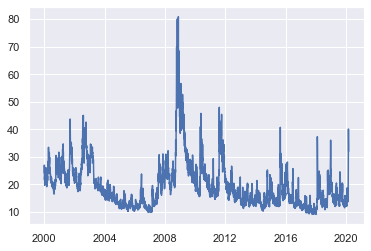

In [3]:
VIX = pd.DataFrame()

VIX['price'] = download_financial_data('^VIX', 'yahoo')['Adj Close']

plt.plot(VIX);

In [4]:
dtVIX = ((VIX.index.shift(1,'B')-VIX.index).to_series().dt.days).values

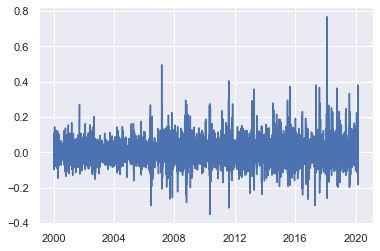

In [5]:
VIX['lret'] = np.log(VIX.price/VIX.price.shift(1))  /np.sqrt(dtVIX);
plt.plot(VIX.lret)

In [6]:
VIX['absval'] = np.abs(VIX.lret)

In [7]:
# lnElnVIX = []
# for i in range(1,6):
#     lnElnVIX.append(np.log((VIX.absval**i).mean()))

In [8]:
lnElnVIX = []
freqs = np.arange(1,61,1)
moments = np.arange(1,6,1)
for i in freqs:
    freqln = []
    dfi = VIX['price'][0::i]
    deltaT =( (dfi.index.to_series().shift(-1)-dfi.index.to_series()) .dt.days ).values
    logret = np.log(dfi/dfi.shift(1) )     
#     / np.sqrt(deltaT)
#     logret = np.log(dfi)
    absval = logret.abs()
    for j in moments:
        freqln.append(np.log((absval**j).mean()))
    lnElnVIX.append(freqln)

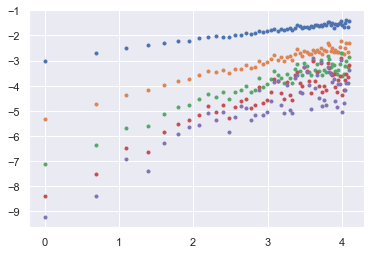

In [9]:
lnElnVIX = np.array(lnElnVIX)
plt.plot(np.log(freqs),lnElnVIX, '.');

In [10]:
models = []
for row in lnElnVIX.T:
    models.append(sm.OLS(row, sm.add_constant(np.log(freqs))).fit())

slopes = []
intercepts = []
for m in models:
    slopes.append(m.params[1])
    intercepts.append(m.params[0])

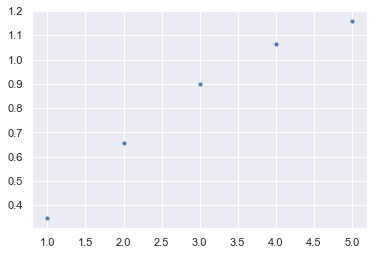

In [11]:
plt.plot(moments,slopes, '.')

In [12]:
VIXhurst = sm.OLS(slopes, sm.add_constant(moments)).fit()
VIXhurst = np.polyfit(moments, slopes, 1)
VIXhurst[0]

0.2037700986266538

In [13]:
for i in moments:
    print(intercepts[i-1]/i)

-2.881299620820633
-2.525542101525404
-2.2086891249603853
-1.9175108347203667
-1.661801424913105


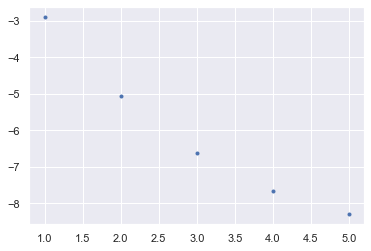

In [14]:
plt.plot(moments, intercepts, '.')

In [15]:
SPY = pd.DataFrame()
SPY['price'] = download_financial_data('^GSPC', 'yahoo')['Adj Close']

In [16]:
lnElnSPY = []
freqs = np.arange(1,31,1)
moments = np.arange(1,11,1)
for i in freqs:
    freqln = []
    dfi = SPY['price'][0::i]
    deltaT =( (dfi.index.to_series().shift(-1)-dfi.index.to_series()) .dt.days ).values
    logret = np.log(dfi/dfi.shift(1) ) 
#     / np.sqrt(deltaT)
#     logret = np.log(dfi)
    absval = logret.std()
    for j in moments:
        freqln.append(np.log((absval**j).mean()))
    lnElnSPY.append(freqln)

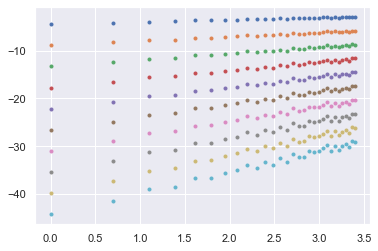

In [17]:
lnElnSPY = np.array(lnElnSPY)
plt.plot(np.log(freqs),lnElnSPY, '.');

In [18]:
spymodels = []
spyslopes = []
spyintercepts = []
for row in lnElnSPY.T:
    m = np.polyfit(np.log(freqs), row, 1)
    spyslopes.append(m[0])
    spyintercepts.append(m[1])
#     spymodels.append(sm.OLS(row, sm.add_constant(np.log(freqs))).fit())


# for m in spymodels:
#     spyslopes.append(m.params[1])
#     spyintercepts.append(m.params[0])

In [19]:
SPYhurst = sm.OLS(spyslopes, sm.add_constant(moments)).fit()
SPYhurst.summary()

C:\Users\steve\Anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.698e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          1.06e-120
Time:                        20:47:11   Log-Likelihood:                 327.11
No. Observations:                  10   AIC:                            -650.2
Df Residuals:                       8   BIC:                            -649.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.166e-15   1.15e-15     -1.014      0.340   -3.82e-15    1.48e-15
x1             0.4421   1.85e-16   2.39e+15      0.000       0.442       0.442
==============================================================================
Omnibus:                        3.859   Durbin-Watson:                   1.229
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                1.938
Skew:                          -1.075   Prob(JB):                        0.379
Kurtosis:                       2.821   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

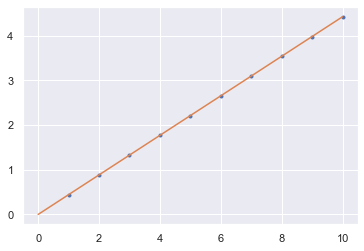

In [20]:
plt.plot(moments,spyslopes, '.')
plt.plot([0,10],[SPYhurst.params[0], SPYhurst.params[0] + 10*SPYhurst.params[1]])

In [21]:
SPCE = pd.DataFrame()
SPCE['price'] = download_financial_data('SPCE', 'yahoo')['Adj Close']

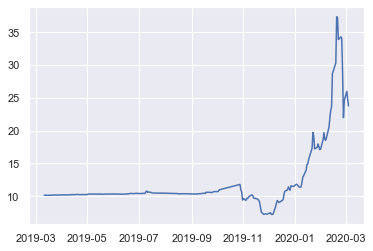

In [22]:
plt.plot(SPCE[-252:])

In [23]:
# lnElnSPCE = []
# freqs = np.arange(1,31,1)
# moments = np.arange(1,11,1)
# for i in freqs:
#     freqln = []
#     dfi = SPCE['price'][0::i]
#     deltaT =( (dfi.index.to_series().shift(-1)-dfi.index.to_series()) .dt.days ).values
#     logret = np.log(dfi/dfi.shift(1) )     / np.sqrt(deltaT)
# #     logret = np.log(dfi)
#     absval = logret.std()
#     for j in moments:
#         freqln.append(np.log((absval**j).mean()))
#     lnElnSPCE.append(freqln)

In [24]:
def HurstDisplays(ticker, start = '2000-01-01', end = dt.date.today()):
    df = pd.DataFrame()
    df['price']  = download_financial_data(ticker, 'yahoo', start, end)['Adj Close']
#     plt.plot(df['price'])
    lnEln = []
    freqs = np.arange(1,151,1)
#     freqs = np.array([1,2,5,10,15,20,25,30,45,60,75,90,100,150,200,300])
    moments = np.arange(1,7,1)

    for i in freqs:
        freqln = []
        dfi = df['price'][0::i]
        deltaT =( (dfi.index.to_series().shift(-1)-dfi.index.to_series()) .dt.days ).values
        logret = np.log(dfi/dfi.shift(1) ) 
#         / np.sqrt(deltaT)
    #     logret = np.log(dfi)
        absval = logret.std()
#         *np.sqrt(252/i)
        for j in moments:
            freqln.append(np.log((absval**j).mean()))
        lnEln.append(freqln)
    lnEln = np.array(lnEln)
    annfreqs = freqs/252
    fig, (ax, bx) = plt.subplots(ncols = 2)
    ax.plot(np.log(annfreqs),lnEln, '.');
#     models = []
#     for row in lnEln.T:
#         models.append(sm.OLS(row, sm.add_constant(np.log(annfreqs))).fit())

    slopes = []
    intercepts = []
    graphm = 0
    graphmoments = []
    for row in lnEln.T:
        graphm += 1
        try:
            m = np.polyfit(np.log(annfreqs), row, 1)
            slopes.append(m[0])
            intercepts.append(m[1])
            graphmoments.append(graphm)
        except:
            print("Something didn't work")
    bx.plot(graphmoments,slopes, '.')
    h = None
    hurst = None
    try:
        hurst = sm.OLS(slopes, sm.add_constant(graphmoments)).fit()
        h = np.polyfit(graphmoments, slopes, 1)[0]
    except:
        print("Final graphing didn't work")
 
    fig.show()
    print("Estimated Hurst coefficient:",h)
    return hurst

In [25]:
def HurstDisplaysLevel(ticker, start = '2000-01-01', end = dt.date.today()):
    df = pd.DataFrame()
    df['price']  = download_financial_data(ticker, 'yahoo', start, end)['Adj Close']
#     plt.plot(df['price'])
    lnEln = []
    freqs = np.arange(1,151,1)
#     freqs = np.array([1,2,5,10,15,20,25,30,45,60,75,90,100,150,200,300])
    moments = np.arange(1,7,1)
    for i in freqs:
        freqln = []
        dfi = df['price'][0::i]
#         deltaT =( (dfi.index.to_series().shift(-1)-dfi.index.to_series()) .dt.days ).values
#         logret = np.log(dfi/dfi.shift(1) ) 
#         / np.sqrt(deltaT)
    #     logret = np.log(dfi)
        absval = dfi.std()
#         *np.sqrt(252/i)
        for j in moments:
            freqln.append(np.log((absval**j).mean()))
        lnEln.append(freqln)
    lnEln = np.array(lnEln)
    annfreqs = freqs/252
    fig, (ax, bx) = plt.subplots(ncols = 2)
    ax.plot(np.log(annfreqs),np.log(lnEln), '.');
    models = []
    for row in lnEln.T:
        models.append(sm.OLS(row, sm.add_constant(np.log(annfreqs))).fit())

    slopes = []
    intercepts = []
    for m in models:
        slopes.append(m.params[1])
        intercepts.append(m.params[0])
    bx.plot(moments,slopes, '.')
    hurst = sm.OLS(slopes, sm.add_constant(moments)).fit()
    fig.show()
    return hurst

def HurstDisplaysVol(ticker, start = '2000-01-01', end = dt.date.today()):
    df = pd.DataFrame()
    df['price']  = download_financial_data(ticker, 'yahoo', start, end)['Adj Close']
#     plt.plot(df['price'])
    lnEln = []
    freqs = np.arange(1,151,1)
#     freqs = np.array([1,2,5,10,15,20,25,30,45,60,75,90,100,150,200,300])
    moments = np.arange(1,7,1)
    for i in freqs:
        freqln = []
        dfi = df['price'][0::i]
        logret = np.log(dfi/dfi.shift(1) )   
#         deltaT =( (dfi.index.to_series().shift(-1)-dfi.index.to_series()) .dt.days ).values
#         logret = np.log(dfi/dfi.shift(1) ) 
#         / np.sqrt(deltaT)
    #     logret = np.log(dfi)
        absval = logret.abs()
#         *np.sqrt(252/i)
        for j in moments:
            freqln.append(np.log((absval**j).mean()))
        lnEln.append(freqln)
    lnEln = np.array(lnEln)
    annfreqs = freqs/252
    fig, (ax, bx) = plt.subplots(ncols = 2)
    ax.plot(np.log(annfreqs),np.log(lnEln), '.');
    models = []
    for row in lnEln.T:
        models.append(sm.OLS(row, sm.add_constant(np.log(annfreqs))).fit())

    slopes = []
    intercepts = []
    for m in models:
        slopes.append(m.params[1])
        intercepts.append(m.params[0])
    bx.plot(moments,slopes, '.')
    hurst = sm.OLS(slopes, sm.add_constant(moments)).fit()
    fig.show()
    return hurst

Something didn't work
Something didn't work
Something didn't work
Something didn't work
Something didn't work
Something didn't work
Final graphing didn't work
Estimated Hurst coefficient: None


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


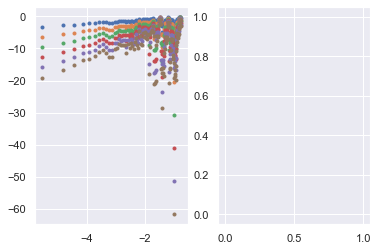

In [27]:
SPCE = HurstDisplays('SPCE', '2018-01-01')
if SPCE != None:
    SPCE.summary()

Estimated Hurst coefficient: 0.5025622038850258


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.753e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           7.92e-61
Time:                        20:52:56   Log-Likelihood:                 198.52
No. Observations:                   6   AIC:                            -393.0
Df Residuals:                       4   BIC:                            -393.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.665e-15   1.18e-15     -1.412      0.231   -4.94e-15    1.61e-15
x1             0.5026   3.03e-16   1.66e+15      0.000       0.503       0.503
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.962
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.453
Skew:                           0.068   Prob(JB):                        0.797
Kurtosis:                       1.661   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

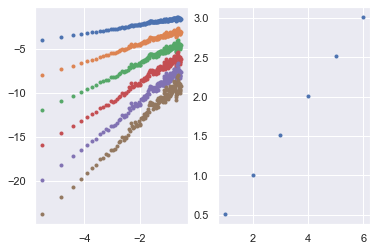

In [28]:
GOOG = HurstDisplays('GOOG', '2000-01-01')
GOOG.summary()

Something didn't work
Something didn't work
Something didn't work
Something didn't work
Something didn't work
Something didn't work
Final graphing didn't work
Estimated Hurst coefficient: None


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


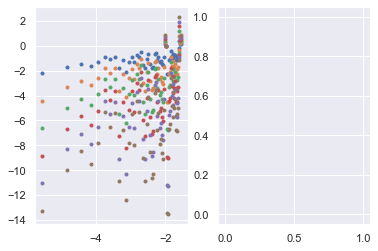

In [30]:
test = HurstDisplays('APT', '2019-10-01')
if test != None:
    test.summary()

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Estimated Hurst coefficient: 0.4854694828116494


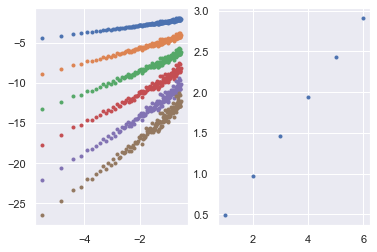

In [31]:
SPYtest = HurstDisplays('SPY')

In [32]:
SPYtest.summary()

C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.879e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.70e-60
Time:                        20:53:22   Log-Likelihood:                 197.58
No. Observations:                   6   AIC:                            -391.2
Df Residuals:                       4   BIC:                            -391.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.551e-16   1.38e-15     -0.402      0.708   -4.38e-15    3.27e-15
x1             0.4855   3.54e-16   1.37e+15      0.000       0.485       0.485
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.593
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.671
Skew:                          -0.422   Prob(JB):                        0.715
Kurtosis:                       1.595   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Estimated Hurst coefficient: 0.5086418804862983


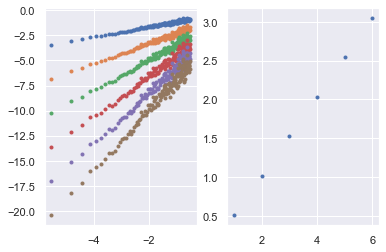

In [33]:
TSLA = HurstDisplays('TSLA')

In [34]:
TSLA.summary()

C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.535e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           2.92e-61
Time:                        20:53:24   Log-Likelihood:                 199.94
No. Observations:                   6   AIC:                            -395.9
Df Residuals:                       4   BIC:                            -396.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.661e-16    9.3e-16     -0.716      0.514   -3.25e-15    1.92e-15
x1             0.5086   2.39e-16   2.13e+15      0.000       0.509       0.509
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.617
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.695
Skew:                          -0.307   Prob(JB):                        0.707
Kurtosis:                       1.450   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Estimated Hurst coefficient: 0.4750065639881525


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.164e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           5.99e-61
Time:                        20:53:26   Log-Likelihood:                 199.27
No. Observations:                   6   AIC:                            -394.5
Df Residuals:                       4   BIC:                            -395.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.665e-15   1.04e-15     -1.601      0.185   -4.55e-15    1.22e-15
x1             0.4750   2.67e-16   1.78e+15      0.000       0.475       0.475
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.647
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.458
Skew:                           0.456   Prob(JB):                        0.795
Kurtosis:                       2.000   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

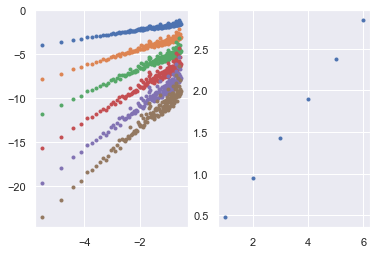

In [35]:
GE = HurstDisplays('GE')
GE.summary()

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Estimated Hurst coefficient: 0.4715853114024608


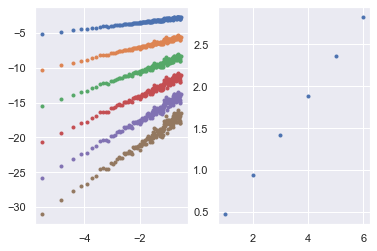

In [36]:
GBP = HurstDisplays('GBP')

In [37]:
GBP.summary()

C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.461e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           2.81e-60
Time:                        20:53:29   Log-Likelihood:                 197.00
No. Observations:                   6   AIC:                            -390.0
Df Residuals:                       4   BIC:                            -390.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.11e-16   1.52e-15     -0.073      0.945   -4.33e-15    4.11e-15
x1             0.4716    3.9e-16   1.21e+15      0.000       0.472       0.472
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.667
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.617
Skew:                          -0.615   Prob(JB):                        0.735
Kurtosis:                       2.022   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in log
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


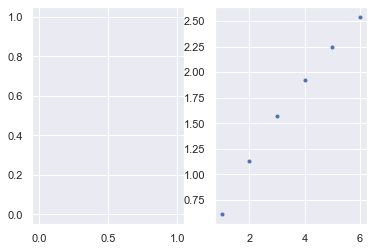

In [38]:
VIXtest = HurstDisplaysVol('VIX')

In [39]:
VIXtest.summary()

C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     318.5
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           5.79e-05
Time:                        20:53:31   Log-Likelihood:                 7.1949
No. Observations:                   6   AIC:                            -10.39
Df Residuals:                       4   BIC:                            -10.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3362      0.083      4.043      0.016       0.105       0.567
x1             0.3811      0.021     17.847      0.000       0.322       0.440
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.106
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.630
Skew:                          -0.343   Prob(JB):                        0.730
Kurtosis:                       1.568   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Estimated Hurst coefficient: 0.5633539049842483


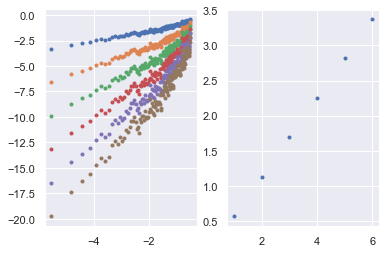

In [53]:
VX2 = HurstDisplays('VIX') #Using the given functions, this is a test of vol of vol?

In [41]:
VX2.summary()

C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.883e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.69e-60
Time:                        20:53:32   Log-Likelihood:                 196.69
No. Observations:                   6   AIC:                            -389.4
Df Residuals:                       4   BIC:                            -389.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.551e-16    1.6e-15     -0.347      0.746   -4.99e-15    3.88e-15
x1             0.5634   4.11e-16   1.37e+15      0.000       0.563       0.563
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.369
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.491
Skew:                          -0.393   Prob(JB):                        0.782
Kurtosis:                       1.839   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Estimated Hurst coefficient: 0.4616912216326635


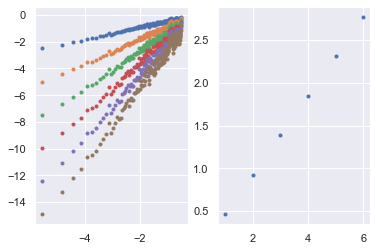

In [42]:
CPHI = HurstDisplays('CPHI')

In [43]:
CPHI.summary()

C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.690e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           8.29e-61
Time:                        20:53:34   Log-Likelihood:                 198.95
No. Observations:                   6   AIC:                            -393.9
Df Residuals:                       4   BIC:                            -394.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.882e-16    1.1e-15     -0.810      0.463   -3.93e-15    2.16e-15
x1             0.4617   2.81e-16   1.64e+15      0.000       0.462       0.462
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.322
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.568
Skew:                          -0.336   Prob(JB):                        0.753
Kurtosis:                       1.651   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Estimated Hurst coefficient: 0.4553826011471739


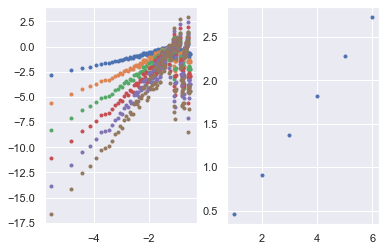

In [44]:
FTSV = HurstDisplays('FTSV')

In [45]:
FTSV.summary()

C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.016e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.48e-60
Time:                        20:53:36   Log-Likelihood:                 198.17
No. Observations:                   6   AIC:                            -392.3
Df Residuals:                       4   BIC:                            -392.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.437e-16   1.25e-15     -0.755      0.492   -4.41e-15    2.52e-15
x1             0.4554   3.21e-16   1.42e+15      0.000       0.455       0.455
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.350
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.244
Skew:                          -0.421   Prob(JB):                        0.885
Kurtosis:                       2.482   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Estimated Hurst coefficient: 0.5754286709676211


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.957e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.57e-60
Time:                        20:53:38   Log-Likelihood:                 196.68
No. Observations:                   6   AIC:                            -389.4
Df Residuals:                       4   BIC:                            -389.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.332e-15    1.6e-15     -0.832      0.452   -5.78e-15    3.12e-15
x1             0.5754   4.11e-16    1.4e+15      0.000       0.575       0.575
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.505
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.297
Skew:                          -0.282   Prob(JB):                        0.862
Kurtosis:                       2.068   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

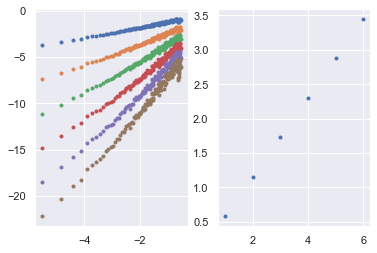

In [46]:
OIL = HurstDisplays('OIL')
OIL.summary()

Estimated Hurst coefficient: 0.4508635842442075


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.644e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           2.22e-60
Time:                        20:53:40   Log-Likelihood:                 197.62
No. Observations:                   6   AIC:                            -391.2
Df Residuals:                       4   BIC:                            -391.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.277e-15   1.37e-15     -0.932      0.404   -5.08e-15    2.52e-15
x1             0.4509   3.52e-16   1.28e+15      0.000       0.451       0.451
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.463
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.324
Skew:                          -0.169   Prob(JB):                        0.850
Kurtosis:                       1.913   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

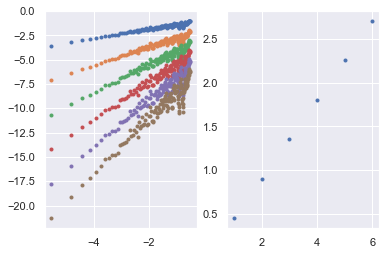

In [47]:
OIL16 = HurstDisplays('OIL', '2016-01-01')
OIL16.summary()

Oil is either mean reverting or not depending on timescale, which is infuriating.

Estimated Hurst coefficient: 0.4332710499074046


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.952e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.58e-60
Time:                        20:53:41   Log-Likelihood:                 198.37
No. Observations:                   6   AIC:                            -392.7
Df Residuals:                       4   BIC:                            -393.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.499e-15   1.21e-15     -1.241      0.282   -4.85e-15    1.85e-15
x1             0.4333    3.1e-16    1.4e+15      0.000       0.433       0.433
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.146
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.643
Skew:                          -0.263   Prob(JB):                        0.725
Kurtosis:                       1.485   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

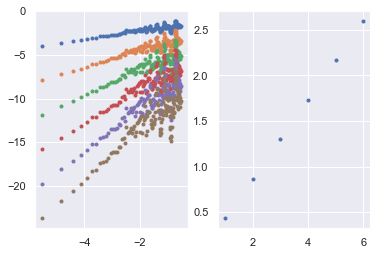

In [48]:
OIL18 = HurstDisplays('OIL', '2018-01-01')
OIL18.summary()

Estimated Hurst coefficient: 0.510743307131832


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.738e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           8.00e-61
Time:                        20:53:43   Log-Likelihood:                 198.40
No. Observations:                   6   AIC:                            -392.8
Df Residuals:                       4   BIC:                            -393.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.441e-16    1.2e-15     -0.369      0.731   -3.78e-15    2.89e-15
x1             0.5107   3.09e-16   1.65e+15      0.000       0.511       0.511
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.689
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.666
Skew:                          -0.744   Prob(JB):                        0.717
Kurtosis:                       2.331   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

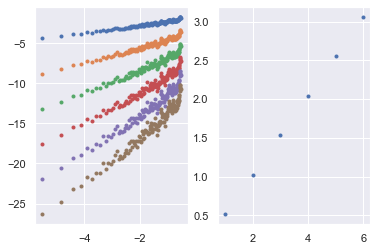

In [49]:
SPY08 = HurstDisplays('SPY', '2008-01-01')
SPY08.summary()

Estimated Hurst coefficient: 0.26265682256898015


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.587e+29
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.92e-59
Time:                        20:53:46   Log-Likelihood:                 197.62
No. Observations:                   6   AIC:                            -391.2
Df Residuals:                       4   BIC:                            -391.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.11e-15   1.37e-15      0.811      0.463   -2.69e-15    4.91e-15
x1             0.2627   3.51e-16   7.47e+14      0.000       0.263       0.263
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.950
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.260
Skew:                           0.446   Prob(JB):                        0.878
Kurtosis:                       2.506   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

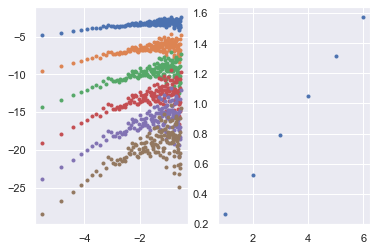

In [50]:
SPY16 = HurstDisplays('SPY', '2016-01-01')
SPY16.summary()

Estimated Hurst coefficient: 0.2862180052678099


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.917e+29
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.71e-59
Time:                        20:53:47   Log-Likelihood:                 197.28
No. Observations:                   6   AIC:                            -390.6
Df Residuals:                       4   BIC:                            -391.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.106e-16   1.45e-15     -0.421      0.695   -4.63e-15    3.41e-15
x1             0.2862   3.72e-16   7.69e+14      0.000       0.286       0.286
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.252
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.103
Skew:                          -0.172   Prob(JB):                        0.950
Kurtosis:                       2.456   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

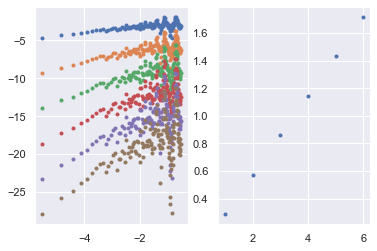

In [51]:
SPY1820 = HurstDisplays('SPY', '2018-01-01', '2020-01-01')
SPY1820.summary()

Estimated Hurst coefficient: 0.6099991867407637


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.727e+30
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.83e-61
Time:                        20:53:49   Log-Likelihood:                 199.55
No. Observations:                   6   AIC:                            -395.1
Df Residuals:                       4   BIC:                            -395.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.221e-15   9.93e-16     -1.230      0.286   -3.98e-15    1.53e-15
x1             0.6100   2.55e-16   2.39e+15      0.000       0.610       0.610
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.295
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.403
Skew:                          -0.510   Prob(JB):                        0.817
Kurtosis:                       2.242   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

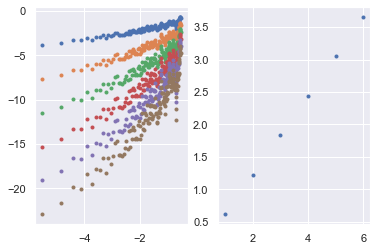

In [52]:
SPY0810 = HurstDisplays('SPY', '2008', '2010')
SPY0810.summary()

Sometimes, the processes themselves seem to evolve in an undecipherable manner. It appears that Hurst exponent for the SPY varies based on exactly when the analysis is done. I don't know whether H is supposed to be invariant or whether H itself is driven by some process, but it does not appear to be invariant in this implmentation.

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in log
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     728.7
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.12e-05
Time:                        21:27:08   Log-Likelihood:                 9.1629
No. Observations:                   6   AIC:                            -14.33
Df Residuals:                       4   BIC:                            -14.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2474      0.060      4.130      0.014       0.081       0.414
x1             0.4153      0.015     26.994      0.000       0.373       0.458
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.076
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.685
Skew:                          -0.364   Prob(JB):                        0.710
Kurtosis:                       1.513   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

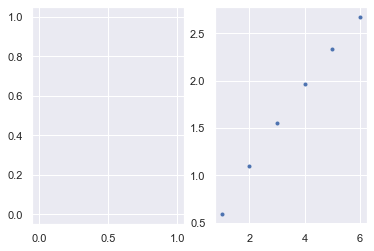

In [55]:
VXZ = HurstDisplaysVol('VXZ')
VXZ.summary()